In [1]:
import os
import torch
import torchvision
import torch.nn as nn
from torch import optim
import numpy as np
import pandas as pd
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline
import time
from torch.autograd import Variable

import cv2
from facenet_pytorch import MTCNN

from PIL import Image


In [2]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [3]:
# device = get_default_device()
device = 'cpu'
device

'cpu'

In [4]:
# We need to get all the paths for the images to later load them
imagepaths = []
labels = []

# Go through all the files and subdirectories inside a folder and save path to images inside list
for root, dirs, files in os.walk("/home/alex/Downloads/leapGestRecog", topdown=False): 
  for name in files:
    path = os.path.join(root, name)
    if path.endswith("png"): # We want only the images
      imagepaths.append(path)
      labels.append(int(path.split("/")[6].split("_")[0][1]))

print(len(imagepaths)) # If > 0, then a PNG image was loaded
print(len(labels))

20000
20000


In [5]:

# This function is used more for debugging and showing results later. It plots the image into the notebook

def plot_image(path):
  img = cv2.imread(path) # Reads the image into a numpy.array
  img_cvt = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Converts into the corret colorspace (RGB)
  print(img_cvt.shape) # Prints the shape of the image just to check
  plt.grid(False) # Without grid so we can see better
  plt.imshow(img_cvt) # Shows the image
  plt.xlabel("Width")
  plt.ylabel("Height")
  plt.title("Image " + path)

(240, 640)


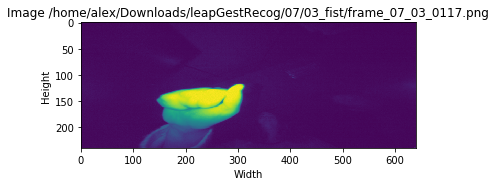

In [6]:
plot_image(imagepaths[0]) #We plot the first image from our imagepaths array

In [7]:
df = pd.DataFrame({
    'img': imagepaths,
    'label': labels
})

df.reset_index(drop=True, inplace=True)
# Выведем первые ять значений нашего датафрейма
print(df.head(5))

                                                 img  label
0  /home/alex/Downloads/leapGestRecog/07/03_fist/...      3
1  /home/alex/Downloads/leapGestRecog/07/03_fist/...      3
2  /home/alex/Downloads/leapGestRecog/07/03_fist/...      3
3  /home/alex/Downloads/leapGestRecog/07/03_fist/...      3
4  /home/alex/Downloads/leapGestRecog/07/03_fist/...      3


In [8]:
class CustomDatasetFromImages(Dataset):
    def __init__(self, data_info):
        # Подаем наш подготовленный датафрейм
        self.data_info = data_info
        
        # Разделяем датафрейм на rgb картинки 
        self.image_arr = self.data_info.iloc[:,0]
        # и на сегментированные картинки
        self.label_arr = self.data_info.iloc[:,1]
        
        # Количество пар картинка-сегментация
        self.data_len = len(self.data_info.index)
    def __getitem__(self, index):
        # Читаем картинку и сразу же представляем ее в виде numpy-массива 
        img = np.asarray(Image.open(self.image_arr[index])).astype('float')
        img = img[..., np.newaxis]
        # Нормализуем изображение в значениях [0,1]
        img = torch.as_tensor(img)/255    
        # permute - меняет местами измерения , т.е. (1, 600, 800, 3) -> (1, 3, 600, 800)
        img = img.permute(2,0,1)
  
        lab = torch.as_tensor(self.label_arr[index])        
        
        
        return (img.float(), lab)

    def __len__(self):
        return self.data_len

In [9]:
from sklearn.model_selection import train_test_split

# 70 % в тренировочную выборку, 30 - в тестовую
X_train, X_test = train_test_split(df,test_size=0.3)

# Упорядочиваем индексацию
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)

# Оборачиваем каждую выборку в наш кастомный датасет
train_data = CustomDatasetFromImages(X_train)
test_data = CustomDatasetFromImages(X_test)

In [10]:
train_data_loader = DataLoader(train_data,batch_size=32,shuffle=True)
test_data_loader = DataLoader(test_data,batch_size=32,shuffle=False)

In [11]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.fc1 = nn.Linear(279552, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dpo1 = nn.Dropout(0.2)
        self.dpo2 = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 279552)
        x = self.dpo1(F.relu(self.fc1(x)))
        x = self.dpo2(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x


net = Net().to(device)

In [12]:
net

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=279552, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (dpo1): Dropout(p=0.2, inplace=False)
  (dpo2): Dropout(p=0.2, inplace=False)
)

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [15]:
for epoch in range(5):  
    running_loss = 0.0
    for i, data in enumerate(train_data_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
#         print(inputs.shape)
        
        optimizer.zero_grad()

        outputs = net(inputs)
#         print(outputs.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        if i % 300 == 0:   
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Training is finished!')

[1,     1] loss: 0.001
[1,   301] loss: 0.089
[2,     1] loss: 0.000
[2,   301] loss: 0.009
[3,     1] loss: 0.000
[3,   301] loss: 0.004
[4,     1] loss: 0.000
[4,   301] loss: 0.004
[5,     1] loss: 0.000
[5,   301] loss: 0.002
Training is finished!


In [19]:
torch.save(net.state_dict(), './models/gesture_recognition.pth')

In [14]:
net=Net().to(device)
net.load_state_dict(torch.load('./models/gesture_recognition.pth'))
net.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=279552, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (dpo1): Dropout(p=0.2, inplace=False)
  (dpo2): Dropout(p=0.2, inplace=False)
)

In [15]:
data_iter = iter(test_data_loader)
images, labels = data_iter.next()

In [16]:
outputs = net(images)

In [17]:
_, predicted = torch.max(outputs, 1)

print('GroundTruth: ', ' '.join('%5s' % labels[j] for j in range(10)))
print('Predicted  : ', ' '.join('%5s' % predicted[j]
                              for j in range(10)))

GroundTruth:  tensor(7) tensor(3) tensor(1) tensor(7) tensor(5) tensor(8) tensor(5) tensor(5) tensor(0) tensor(3)
Predicted  :  tensor(7) tensor(3) tensor(1) tensor(7) tensor(5) tensor(8) tensor(5) tensor(5) tensor(0) tensor(3)


In [43]:
correct = 0
for i, data in enumerate(test_data_loader, 0):
    images, labels = data[0], data[1]

    outputs = net(images)
    _, predicted = torch.max(outputs, 1)

    correct += (labels == predicted).sum()
            
accuracy = 100 * correct / len(test_data_loader.dataset)
print("Accuracy = {}".format(accuracy))

Accuracy = 99.94999694824219


In [61]:
# Создаем объект для считывания потока с веб-камеры(обычно вебкамера идет под номером 0. иногда 1)
cap = cv2.VideoCapture(0)  

# Класс детектирования и обработки лица с веб-камеры 
class FaceDetector(object):

    def __init__(self, mtcnn, net):
        self.mtcnn = mtcnn
#         self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.device = 'cpu'
        self.model = net
    
    # Функция для вырезания лиц с кадра
    @staticmethod
    def crop_faces(frame, boxes):
        faces = []
        for i, box in enumerate(boxes):
            faces.append(frame[int(box[1]):int(box[3]), 
                int(box[0]):int(box[2])])
        return faces

       
    # Функция в которой будет происходить процесс считывания и обработки каждого кадра
    def run(self):              
        # Заходим в бесконечный цикл
        while True:
            # Считываем каждый новый кадр - frame
            # ret - логическая переменая. Смысл - считали ли мы кадр с потока или нет
            ret, frame = cap.read()
            try:
                # детектируем расположение лица на кадре, вероятности на сколько это лицо
                # и особенные точки лица
                boxes, probs, landmarks = self.mtcnn.detect(frame, landmarks=True)
                
#               Копируем изображение, с которым будем дальше работать
                img = frame.copy()

                # Превращаем в 1-канальное серое изображение
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#                 Отрезаем нижнюю часть изображения, по которой будем детектировать жесты
                img = img[240:480,]
                
                img = img/255
                # Превращаем numpy-картинку вырезанного лица в pytorch-тензор
                torch_img = torch.from_numpy(img).unsqueeze(0).to(self.device).float()
                # Загужаем наш тензор лица в нейронную сеть и получаем предсказание
                pred = self.model(torch_img[None, ...])
                
#                 если пользователь показал жест ОК, и при этом присутствует в кадре
#                 то прекращаем выполнение программы
                if len(boxes) and pred.argmax() == 1:
                    break
                

            except:
                print('Something wrong im main cycle!')

            # Показываем кадр в окне, и назвываем его(окно) - 'Face Detection'
            cv2.imshow('Face Detection', frame)
            
            # Функция, которая проверяет нажатие на клавишу 'q'
            # Если нажатие произошло - выход из цикла. Конец работы приложения
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
                
        # Очищаем все объекты opencv, что мы создали
        cap.release()
        cv2.destroyAllWindows()
        
# Загружаем мтцнн
mtcnn = MTCNN()

# Создаем объект нашего класса приложения
fcd = FaceDetector(mtcnn, net)
# Запускаем
fcd.run()